# Автобрея. Проект DaNetQA

**Андрей Якубой, Алиса Лёзина, Полина Уткина**

В этой работе мы проводим небольшое исследование методов решения задачи ответов на вопросы "да"/"нет" для русского языка. Данные вопросы основаны на информации из небольших фрагментов текста, которые идут вместе с вопросами, при этом далеко не всегда ответ на вопрос содержится в тексте напрямую, так что для правильного ответа необходимо понять смысл текста и обладать базовыми способностями рассуждать логически. Представляется, что такой тест позволяет понять, как хорошо конкретная языковая модель способна понимать смысл прочитанного русскоязычного текста, а также, в случае с классификацией и энкодерами - насколько хорошо выбранное векторное представление текста передаёт его смысл.

В этой работе мы используем датасет DaNetQa, который является частью бенчмарка [Russian SuperGlue](https://russiansuperglue.com/).

## 1. Загружаем датасет

In [ ]:
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!wget https://huggingface.co/datasets/RussianNLP/russian_super_glue/resolve/main/data/DaNetQA.zip

--2024-12-27 13:08:05--  https://huggingface.co/datasets/RussianNLP/russian_super_glue/resolve/main/data/DaNetQA.zip
Resolving huggingface.co (huggingface.co)... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


3.168.73.111, 3.168.73.106, 3.168.73.38, ...
Connecting to huggingface.co (huggingface.co)|3.168.73.111|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/datasets/russian_super_glue/b5b4bcfe17e1eb16aa13a7aab4ca088871e27b0851468e9a07b9b528bb42fb96?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27DaNetQA.zip%3B+filename%3D%22DaNetQA.zip%22%3B&response-content-type=application%2Fzip&Expires=1735553285&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNTU1MzI4NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kYXRhc2V0cy9ydXNzaWFuX3N1cGVyX2dsdWUvYjViNGJjZmUxN2UxZWIxNmFhMTNhN2FhYjRjYTA4ODg3MWUyN2IwODUxNDY4ZTlhMDdiOWI1MjhiYjQyZmI5Nj9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10eXBlPSoifV19&Signature=MIlPu%7EEOD592n-Q7q2fMrrF8xTTPiybFvHHuQtv%7ESpHnV4H2cPnJz5cytzz9rkuF6yEpyrQ5uKUfxqChPCHM2-g1jukKtEj4J7ro-6F2nZ1Jj-OdFnCrFwpv-CkfxjsIFBXR%7EYYXMlB6Ekc%7EI39RNjrRvng1b8-i6kI%

In [ ]:
with zipfile.ZipFile("DaNetQA.zip", 'r') as zip_ref:
    zip_ref.extract('DaNetQA/train.jsonl')
    zip_ref.extract('DaNetQA/test.jsonl')
    zip_ref.extract('DaNetQA/val.jsonl')

In [ ]:
train_df = pd.read_json('DaNetQA/train.jsonl', lines=True)
test_df = pd.read_json('DaNetQA/test.jsonl', lines=True)
val_df = pd.read_json('DaNetQA/val.jsonl', lines=True)

## 2. EDA

Посмотрим на формат данных каждой из частей датасета.

In [ ]:
train_df.head()

,question,passage,label,idx
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,0
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,1
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True,2
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010...",True,3
4,Был ли автомат калашникова в вов?,Отметив некоторые недостатки и в целом удачную...,False,4


In [ ]:
test_df.head()

,question,passage,idx
0,Полезна ли ртуть с градусника?,"Отравления ртутью — расстройства здоровья, св...",0
1,Являются ли сапрофаги хищниками?,Фауна лесных почв — совокупность видов животны...,1
2,Водятся ли в индии крокодилы?,"Болотный крокодил, или магер — пресмыкающееся...",2
3,Есть ли в батате крахмал?,"Клубневидно вздутые корни весят до 15 кг, сод...",3
4,Был ли человек в железной маске?,Остров Сент-Маргерит — крупнейший из Лерински...,4


In [ ]:
val_df.head()

,question,passage,label,idx
0,Есть ли вода на марсе?,Гидросфера Марса — это совокупность водных зап...,True,0
1,Состоит ли англия в евросоюзе?,В полночь с 31 января на 1 февраля 2020 года п...,False,1
2,Действительно ли в ссср не было адвокатов?,Семён Львович Ария — советский и российский ю...,False,2
3,Была ли чума в оране?,"Чума — это и абсурд, что осмысливается как фор...",True,3
4,Был ли кетчуп в читосе?,Текущий каталог продукции размещен на сайте пр...,True,4


In [ ]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(1749, 4)
(805, 3)
(821, 4)


Можем видеть, что в тестовой части датасета нет лейблов, что очень логично в силу того, что этот датасет - публичный бенчмарк.

Теперь посмотрим на распределение True и False в трейне и валидации.

In [ ]:
train_df['label'].value_counts()

label
True     1061
False     688
Name: count, dtype: int64

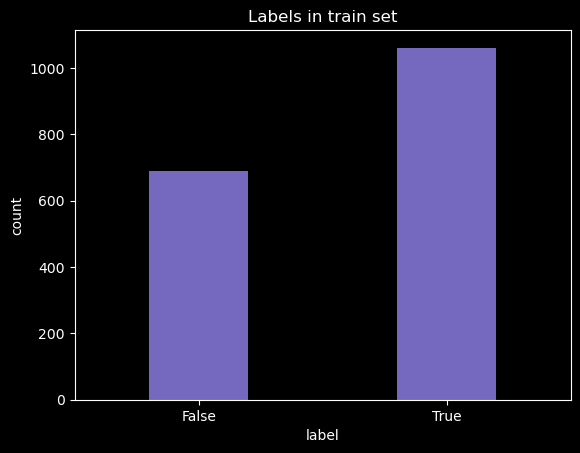

In [ ]:
sns.countplot(x='label', data=train_df, color='slateblue', width=0.4)
plt.title('Labels in train set')
plt.show()

In [ ]:
val_df['label'].value_counts()

label
True     412
False    409
Name: count, dtype: int64

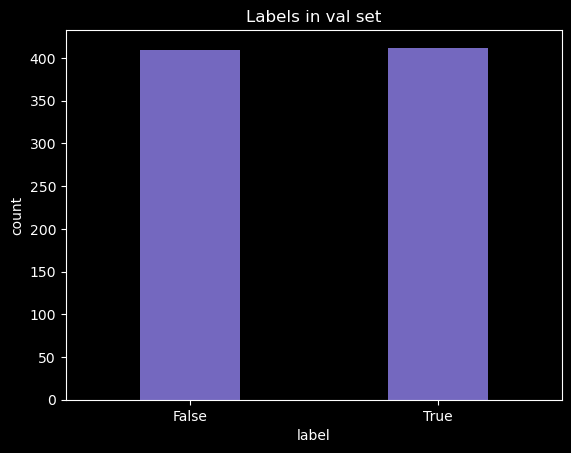

In [ ]:
sns.countplot(x='label', data=val_df, color='slateblue', width=0.4)
plt.title('Labels in val set')
plt.show()

Посмотрим на распределение примерного количества слов в вопросах и текстах для трейна и валидации.

In [ ]:
train_df['question_word_count'] = train_df['question'].apply(
    lambda x: len(x.split()))
train_df['passage_word_count'] = train_df['passage'].apply(
    lambda x: len(x.split()))

In [ ]:
train_df['passage_word_count'].mean()

98.34877072612922

In [ ]:
train_df['question_word_count'].mean()

6.519725557461406

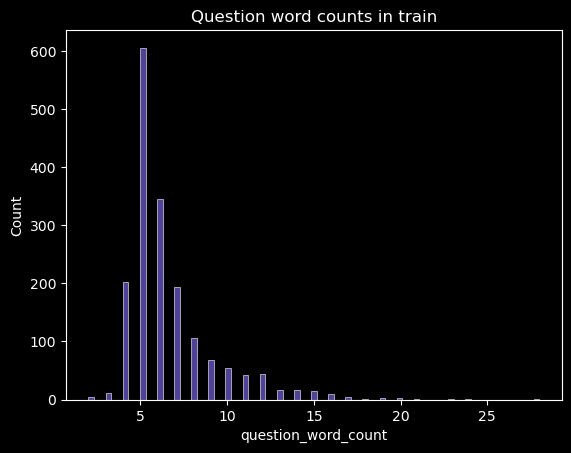

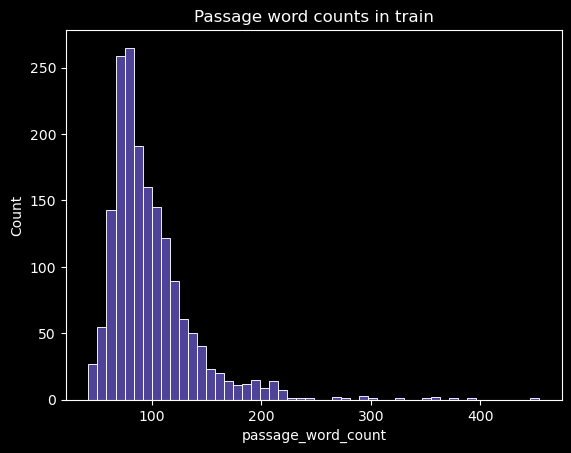

In [ ]:
sns.histplot(train_df['question_word_count'], color='slateblue')
plt.title('Question word counts in train')
plt.show()

sns.histplot(train_df['passage_word_count'], bins=50, color='slateblue')
plt.title('Passage word counts in train')
plt.show()

In [ ]:
val_df['question_word_count'] = val_df['question'].apply(
    lambda x: len(x.split()))
val_df['passage_word_count'] = val_df['passage'].apply(
    lambda x: len(x.split()))

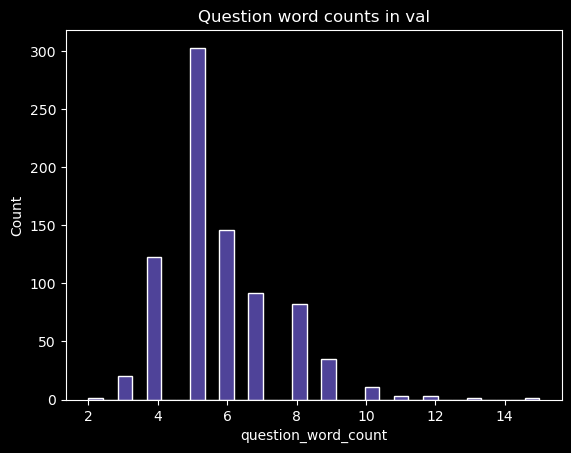

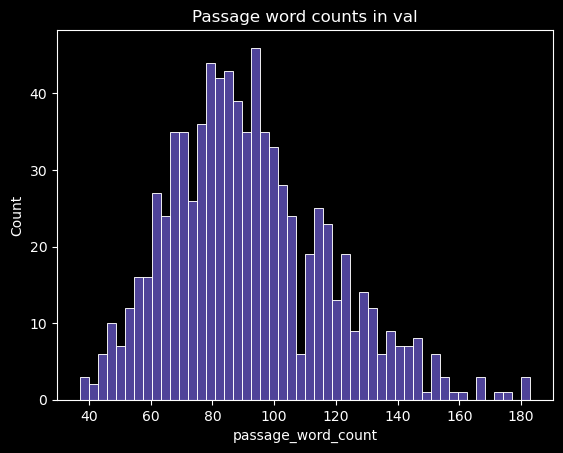

In [ ]:
sns.histplot(val_df['question_word_count'], color='slateblue')
plt.title('Question word counts in val')
plt.show()

sns.histplot(val_df['passage_word_count'], bins=50, color='slateblue')
plt.title('Passage word counts in val')
plt.show()

In [ ]:
val_df['passage_word_count'].mean()

91.74665042630937

In [ ]:
val_df['question_word_count'].mean()

5.806333739342265

In [ ]:
# Удаляем колонки с количеством слов в вопросе и параграфе во всех датасетах

train_df.drop(['question_word_count', 'passage_word_count'],
              axis=1, inplace=True)
val_df.drop(['question_word_count', 'passage_word_count'],
            axis=1, inplace=True)

В целом, что можно сказать про наш датасет?

Он является бенчмарком для задачи бинарного QA.

Состав датасета: вопрос ("question"), текст ("passage"), бинарный ответ ("label" в формате "True/False"), индекс строки ("idx").

Размер датасета: 1789 строк в трейне, 805 строк в тесте и 821 строка в валидации.

В трейне наблюдается некоторый дисбаланс лейблов: 1061 True, 688 False;

Это, возможно, может приводить к некоторому байасу в сторону положительных ответов во время обучения моделей.

Тексты трейна распределены по длине относительно нормально, средняя длина: 98 слов. В случае валидации распределение несколько менее равномерное, средняя длина: 91 слово.


## 3. Определяемся с выборками и метриками

Поскольку оригинальная тестовая выборка бенчмарка не содержит меток, мы не можем использовать её для оценивания. При этом мы имеем достаточно большую валидационную выборку относительно тренировочной (не многим меньше 50%). Для целей нашего проекта разделим валидационную выборку на две равные части с сохранением пропорций классов, и одну из них будем использовать в качестве валидационной выборки, а другую - в качестве тестовой.

В тренировочной выборке присутствует дисбаланс классов, однако в валидационной и тестовой выборках его не будет - поэтому для нас будут показательны как accuracy, так и F1-метрика и её компоненты - precision и recall. Мы будем анализировать все метрики, но судить о качестве модели будем именно по accuracy, так как именно эта метрика используется на лидерборде в Russian SuperGlue, что даёт нам возможность сравнивать результат. Precision, recall и F1 будем использовать для анализа байасов.

In [ ]:
from sklearn.model_selection import train_test_split

# Создаём новые валидационные и тестовые выборки из оригинальной валидационной

new_val_df, new_test_df = train_test_split(
    val_df,
    test_size=0.5,
    random_state=42,
    stratify=val_df['label']
)

In [ ]:
# Проверяем, что дистрибуция классов совпадает с оригинальной
print("Дистрибуция классов в новой валидационной выборке:")
print(new_val_df['label'].value_counts())
print("\nДистрибуция классов в новой тестовой выборке:")
print(new_test_df['label'].value_counts())

Дистрибуция классов в новой валидационной выборке:
label
True     206
False    204
Name: count, dtype: int64

Дистрибуция классов в новой тестовой выборке:
label
True     206
False    205
Name: count, dtype: int64


In [ ]:
# Конвертируем классы в целые числа
train_df['label'] = train_df['label'].astype(int)
new_val_df['label'] = new_val_df['label'].astype(int)
new_test_df['label'] = new_test_df['label'].astype(int)

In [ ]:
# Сохраняем финальные выборки в jsonlines

if not os.path.exists('final_data'):
    os.makedirs('final_data')

train_df.to_json(
    'final_data/train.jsonl',
    orient='records',
    lines=True,
    force_ascii=False)
new_val_df.to_json(
    'final_data/val.jsonl',
    orient='records',
    lines=True,
    force_ascii=False)
new_test_df.to_json(
    'final_data/test.jsonl',
    orient='records',
    lines=True,
    force_ascii=False)

## 4. Baseline

В качестве бейзлайна разработчики Russian SuperGLUE использовали TF-IDF и логистическую регрессию ([источник](https://github.com/RussianNLP/RussianSuperGLUE/blob/master/tfidf_baseline/DaNetQA.py)). Нам показалось это хорошим решением в качестве стартовой точки, однако в оригинальном бейзлайне есть моменты, которые нас смутили.

1. Авторы подавали на вход только вопросы и ответы, никак не учитывая текстовые фрагменты, в которых можно было бы найти ответ на вопрос.
2. Авторы никак не предобрабатывали текст, подаваемый в TF-IDF, не проводилась даже лемматизация и удаление стоп-слов.

Кроме того, в авторском бейзлайне используется векторизатор TF-IDF, обученный на всём тренировочном корпусе бенчмарка, а не только на датасете DaNetQA. Мы же в данном проекте ориентируемся не на весь бенчмарк, а исключительно на этот набор данных. Поэтому, вдохновляясь оригиналом, мы немного модифицировали бейзлайн: добавили лемматизацию и удаление стоп-слов, построили TF-IDF с учётом биграмм, а также провели два эксперимента: в первом в качестве объектов использовались только вопросы, а во втором текст, содержащий ответ, конкатинировался с вопросом.

In [1]:
import codecs
import json
import numpy as np
from pymystem3 import Mystem
from nltk.corpus import stopwords
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


mystem = Mystem()
russian_stopwords = set(stopwords.words("russian"))

In [2]:
def mystem_tokenizer(text):
    # Лемматизируем текст
    lemmas = mystem.lemmatize(text)
    # Возвращаем только алфавитные токены, которых нет в списке стоп-слов, а
    # также цифры
    tokens = [
        token for token in lemmas
        if token.strip() and
        ((token.isalpha() and
          token not in russian_stopwords) or
         token.isdigit())
    ]
    return tokens

In [3]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=mystem_tokenizer,
    ngram_range=(1, 2)
)

In [4]:
# две функции для считывания данных из файлов
def build_feature_DaNetQA(row):
    res = str(row["question"]).strip()
    label = row.get("label")
    return res, label


def read_data_DaNetQA(path):
    with codecs.open(path, encoding='utf-8-sig') as reader:
        lines = reader.read().split("\n")
        lines = list(map(json.loads, filter(None, lines)))
    res = list(map(build_feature_DaNetQA, lines))
    texts = list(map(lambda x: x[0], res))
    labels = list(map(lambda x: x[1], res))
    ids = [x["idx"] for x in lines]
    return texts, labels, ids


# векторизация tf_idf
def build_features_DaNetQA(path, vect, fit=False):
    texts, labels, ids = read_data_DaNetQA(path)
    if fit:
        features = vect.fit_transform(texts)
    else:
        features = vect.transform(texts)
    return (features, labels), ids


# логистическая регрессия
def fit_DaNetQA(train, labels):
    clf = LogisticRegression(random_state=42)
    return clf.fit(train, labels)


# векторизация считанных данных, обучение логистической регрессии,
# предсказание и оценка качества
def eval_DaNetQA(train_path, val_path, test_path, vectorizer):
    train, train_ids = build_features_DaNetQA(train_path, vectorizer, fit=True)
    val, val_ids = build_features_DaNetQA(val_path, vectorizer, fit=False)
    test, test_ids = build_features_DaNetQA(test_path, vectorizer, fit=False)

    clf = fit_DaNetQA(*train)

    train_pred = clf.predict(train[0])
    val_pred = clf.predict(val[0])
    test_pred = clf.predict(test[0])

    return clf, {
        "train": classification_report(
            train[1], train_pred, target_names=[
                'False', 'True']), "val": classification_report(
            val[1], val_pred, target_names=[
                'False', 'True']), "test": classification_report(
            test[1], test_pred, target_names=['False', 'True'])}

In [5]:
# Обработка данных, оценка результата
_, scores = eval_DaNetQA(
    'final_data/train.jsonl',
    'final_data/val.jsonl',
    'final_data/test.jsonl',
    tfidf_vectorizer
)

# Результаты для каждой выборки
print("Train scores:")
print(scores['train'])
print("\nValidation scores:")
print(scores['val'])
print("\nTest scores:")
print(scores['test'])

/home/futyn/miniconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train scores:
              precision    recall  f1-score   support

       False       0.99      0.84      0.91       688
        True       0.90      1.00      0.95      1061

    accuracy                           0.93      1749
   macro avg       0.95      0.92      0.93      1749
weighted avg       0.94      0.93      0.93      1749


Validation scores:
              precision    recall  f1-score   support

       False       0.79      0.17      0.28       204
        True       0.54      0.96      0.69       206

    accuracy                           0.56       410
   macro avg       0.66      0.56      0.48       410
weighted avg       0.66      0.56      0.48       410


Test scores:
              precision    recall  f1-score   support

       False       0.79      0.15      0.25       205
        True       0.53      0.96      0.69       206

    accuracy                           0.56       411
   macro avg       0.66      0.56      0.47       411
weighted avg       0.66   

## Объединим тексты и вопросы

Интуитивно кажется, что если в классифицируемом тексте будет информация, которая позволит верно определить ответ, то классификация пройдёт лучше, поэтому перепишим функцию `build_feature_DaNetQA` так, чтобы информационный текст и вопрос конкатинировались в единое целое - именно это мы будем подавать на вход классификатору как объект.

In [6]:
def build_feature_DaNetQA(row):
    res = str(row["question"]).strip() + " " + str(row["passage"]).strip()
    label = row.get("label")
    return res, label

In [7]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=mystem_tokenizer,
    ngram_range=(1, 2)
)

In [8]:

_, scores = eval_DaNetQA(
    'final_data/train.jsonl',
    'final_data/val.jsonl',
    'final_data/test.jsonl',
    tfidf_vectorizer
)

print("Train scores:")
print(scores['train'])
print("\nValidation scores:")
print(scores['val'])
print("\nTest scores:")
print(scores['test'])

/home/futyn/miniconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train scores:
              precision    recall  f1-score   support

       False       0.99      0.77      0.86       688
        True       0.87      0.99      0.93      1061

    accuracy                           0.91      1749
   macro avg       0.93      0.88      0.90      1749
weighted avg       0.92      0.91      0.90      1749


Validation scores:
              precision    recall  f1-score   support

       False       0.93      0.12      0.22       204
        True       0.53      0.99      0.69       206

    accuracy                           0.56       410
   macro avg       0.73      0.56      0.45       410
weighted avg       0.73      0.56      0.46       410


Test scores:
              precision    recall  f1-score   support

       False       0.82      0.09      0.16       205
        True       0.52      0.98      0.68       206

    accuracy                           0.54       411
   macro avg       0.67      0.53      0.42       411
weighted avg       0.67   

Во-первых, стоит сказать, что в обоих экспериментах мы наблюдаем жёсткое переобучение: метрики на тренировочном наборе данных намного выше, чем на тестовом и валидационном. Однако даже по метрикам на тренировочном наборе заметно, что модель чаще склонна говорить "да", даже если ответ на вопрос отрицательный - это видно по метрике recall. На тестовом и валидационном наборах данных "yes-bias" модели совсем критичный: для ответов "да" recall почти стопроцентный, тогда как для "нет" едва ли больше 10%, то есть модель почти всегда говорит "да". Видимо, это происходит из-за дисбаланса данных в тренировочной выборке, где вопросов с правильным утвердительным ответом больше.

Во-вторых, вопреки ожиданиям, добавление дополнительной информации в виде фрагмента текста ухудшило результат. Это можно связать с тем, что логистическая регрессия не способна моделировать логические отношения между текстом и вопросом, да и представление TF-IDF для этого не подходит, потому что не содержит никакой информации о семантике - в итоге когда мы добавляем больше текста, появляется больше шума, а новой информации для обобщения не появляется.

В целом, baseline-модель вообще не выучила никаких закономерностей и получилась почти константной, что говорит о том, что TF-IDF не подходит для моделирования логической связи между вопросом и текстом, в котором этот вопрос содержится, да и логистическая регрессия, видимо, тоже. Для решения задачи стоит задействовать глубокое обучение, как для получения адекватного представления текста, так и для классификации, или, что ещё лучше, перейти от задачи классификации к задаче генерации.

In [ ]:
!mkdir exp_preds

## 5. Классификация с помощью предобученного инструктивного энкодера и MLP

Современные энкодеры способны эффективно вычислять эмбеддинги сразу для предложений. Они специально обучались на множестве датасетов под разные задачи: классификация, кластеризация, QA, информационный поиск и так далее. Есть несколько SOTA-энкодеров, которые обучались с использованием инструкций - это значит, что они могут строить разные эмбеддинги в зависимости от данных инструкций: одни будут больше подходить для классификации, другие - для кластеризации, и так далее. Мы можем взять одну из таких моделей, а именно, [multilingual-e5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct), составить инструкцию для бинарного QA, получить высококачественные эмбеддинги и обучить простой MLP-классификатор с их использованием.

Это, во-первых, требует меньше памяти, чем fine-tuning трансформера, во-вторых, потенциально может дать даже лучший результат за счёт того, что модель обучена на разных supervised-датасетах и может производить высококачественные представления текста.

При обучении будем подбирать гиперпараметры: learning rate, dropout и weight_decay - в надежде побороть переобучение. Подбирать будем последовательно в вышеперечисленном порядке.

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

2024-12-27 16:15:27.723090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 16:15:27.737539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735316127.754091  101887 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735316127.759063  101887 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 16:15:27.776770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Фиксируем seed везде, где можем
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_random_seed(42)

In [ ]:
# Класс датасета
class DaNetQADataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings.cpu()
        self.labels = labels

    def __len__(self):
        # Возвращаем количество объектов в датасете
        return len(self.labels)

    def __getitem__(self, idx):
        # Возвращаем конкретный объект по индексу
        return self.embeddings[idx], torch.tensor(
            self.labels[idx], dtype=torch.long)

In [ ]:
# Простая MLP-нейросеть
class MLP(nn.Module):
    def __init__(
            self,
            input_dim=1024,  # размер эмбеддинга
            hidden_dim=512,  # скрытый слой
            dropout_rate=0.3,  # регуляризация
            num_classes=2):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim // 2)
        self.fc3 = nn.Linear(self.hidden_dim // 2, num_classes)

        self.norm1 = nn.LayerNorm(self.hidden_dim)
        self.norm2 = nn.LayerNorm(self.hidden_dim // 2)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.dropout(F.relu(self.norm1(self.fc1(x))))
        x = self.dropout(F.relu(self.norm2(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# Классификатор на основе PyTorch-Lightning
class DaNetQAClassifier(pl.LightningModule):
    def __init__(
            self,
            train_dataset,
            val_dataset,
            batch_size=32,
            lr=1e-3,
            dropout_rate=0.3,
            weight_decay=1e-5):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.f1_score = BinaryF1Score()
        self.accuracy_score = BinaryAccuracy()

        self.model = MLP(
            input_dim=1024,
            dropout_rate=dropout_rate,
            num_classes=2)
        self.save_hyperparameters(ignore=['train_dataset', 'val_dataset'])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        # Считаем и логируем метрики
        f1 = self.f1_score(preds, y)
        accuracy = self.accuracy_score(preds, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_f1', f1, prog_bar=True)
        self.log('train_acc', accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        f1 = self.f1_score(preds, y)
        accuracy = self.accuracy_score(preds, y)
        # Считаем и логируем метрики
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)
        self.log('val_acc', accuracy, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",
                "frequency": 1
            }
        }

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=15, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=15,
            pin_memory=True)

Наша инструкция будет выглядеть следующим образом:

> Given a question and the passage, answer 'yes' or 'no' to this question based on the passage

Далее мы объединим текстовый фрагмент и вопрос в формате `Passage: {passage}\nQuestion: {question}`.

In [ ]:
# Функция для получения эмбеддингов
def get_embeddings(questions, passages):
    model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')

    instruction = "Given a question and the passage, answer 'yes' or 'no' to this question based on the passage"
    formatted_inputs = [
        f"Instruct: {instruction}\nQuery: Question: {q}\nPassage: {p}"
        for q, p in zip(questions, passages)
    ]

    embeddings = model.encode(
        formatted_inputs,
        normalize_embeddings=True,
        show_progress_bar=True,
        batch_size=32,
        convert_to_tensor=True
    )
    return embeddings

In [ ]:
train_df = pd.read_json('final_data/train.jsonl', lines=True)
val_df = pd.read_json('final_data/val.jsonl', lines=True)
test_df = pd.read_json('final_data/test.jsonl', lines=True)

train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

In [ ]:
train_embeddings = get_embeddings(
    train_df['question'].tolist(),
    train_df['passage'].tolist())
torch.save(train_embeddings, 'final_data/train_embeddings.pt')

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

In [ ]:
val_embeddings = get_embeddings(
    val_df['question'].tolist(),
    val_df['passage'].tolist())
torch.save(val_embeddings, 'final_data/val_embeddings.pt')

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
test_embeddings = get_embeddings(
    test_df['question'].tolist(),
    test_df['passage'].tolist())
torch.save(test_embeddings, 'final_data/test_embeddings.pt')

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
# Загружаем сохранённые в файлы эмбеддинги
train_embeddings = torch.load('final_data/train_embeddings.pt')
val_embeddings = torch.load('final_data/val_embeddings.pt')
test_embeddings = torch.load('final_data/test_embeddings.pt')

train_dataset = DaNetQADataset(train_embeddings, train_labels)
val_dataset = DaNetQADataset(val_embeddings, val_labels)
test_dataset = DaNetQADataset(test_embeddings, test_labels)

/tmp/ipykernel_101887/2589031526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load('final_data/train_embeddings.pt')
/tmp/ipykernel_101887/25

In [ ]:
# Подбираем learning rate
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 2e-5]
best_acc = 0
best_lr = None

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    early_stop_callback = EarlyStopping(
        monitor='val_acc',
        min_delta=0.00,
        patience=10,
        verbose=True,
        mode='max'
    )

    model = DaNetQAClassifier(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=32,
        lr=lr
    )

    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        devices=1,
        callbacks=[early_stop_callback],
        enable_progress_bar=True
    )

    trainer.fit(model)

    if trainer.callback_metrics['val_acc'].item() > best_acc:
        best_acc = trainer.callback_metrics['val_acc'].item()
        best_lr = lr

print(f"\nBest learning rate: {best_lr} (accuracy: {best_acc:.4f})")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | f1_score       | BinaryF1Score  | 0      | train
1 | accuracy_score | BinaryAccuracy | 0      | train
2 | model          | MLP            | 658 K  | train
----------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.633     Total estimated model params size (MB)
9      


Training with learning rate: 1e-05


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.502


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.505


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.059 >= min_delta = 0.0. New best score: 0.563


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.576


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.583


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.024 >= min_delta = 0.0. New best score: 0.607


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.612


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.615


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.617


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.620


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.620. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | f1_score       | BinaryF1Score  | 0      | train
1 | accuracy_score | BinaryAccuracy | 0      | train
2 | model          | MLP            | 658 K  | train
----------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.633     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode



Training with learning rate: 5e-05


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.502


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.144 >= min_delta = 0.0. New best score: 0.646


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.078 >= min_delta = 0.0. New best score: 0.724


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.724. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | f1_score       | BinaryF1Score  | 0      | train
1 | accuracy_score | BinaryAccuracy | 0      | train
2 | model          | MLP            | 658 K  | train
----------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.633     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode



Training with learning rate: 0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.556


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.561


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.120 >= min_delta = 0.0. New best score: 0.680


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.690


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.041 >= min_delta = 0.0. New best score: 0.732


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.737


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.737. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | f1_score       | BinaryF1Score  | 0      | train
1 | accuracy_score | BinaryAccuracy | 0      | train
2 | model          | MLP            | 658 K  | train
----------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.633     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode



Training with learning rate: 0.0005


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.546


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.168 >= min_delta = 0.0. New best score: 0.715


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.724


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.022 >= min_delta = 0.0. New best score: 0.746


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.746. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | f1_score       | BinaryF1Score  | 0      | train
1 | accuracy_score | BinaryAccuracy | 0      | train
2 | model          | MLP            | 658 K  | train
----------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.633     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode



Training with learning rate: 0.001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.551


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.154 >= min_delta = 0.0. New best score: 0.705


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.034 >= min_delta = 0.0. New best score: 0.739


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.739. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | f1_score       | BinaryF1Score  | 0      | train
1 | accuracy_score | BinaryAccuracy | 0      | train
2 | model          | MLP            | 658 K  | train
----------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.633     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode



Training with learning rate: 2e-05


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.502


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.015 >= min_delta = 0.0. New best score: 0.517


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.120 >= min_delta = 0.0. New best score: 0.637


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.046 >= min_delta = 0.0. New best score: 0.683


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.685


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.685. Signaling Trainer to stop.



Best learning rate: 0.0005 (accuracy: 0.7244)


In [ ]:
# Подбираем dropout
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
best_acc = 0
best_dropout = None

for dropout in dropout_rates:
    print(f"\nTraining with dropout rate: {dropout}")

    early_stop_callback = EarlyStopping(
        monitor='val_acc',
        min_delta=0.00,
        patience=10,
        verbose=False,
        mode='max'
    )

    model = DaNetQAClassifier(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=32,
        lr=best_lr,
        dropout_rate=dropout
    )

    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        devices=1,
        callbacks=[early_stop_callback],
        enable_progress_bar=True,
        enable_model_summary=False
    )

    trainer.fit(model)

    if trainer.callback_metrics['val_acc'].item() > best_acc:
        best_acc = trainer.callback_metrics['val_acc'].item()
        best_dropout = dropout

print(f"\nBest dropout rate: {best_dropout} (accuracy: {best_acc:.4f})")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with dropout rate: 0.1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with dropout rate: 0.2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with dropout rate: 0.3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with dropout rate: 0.4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with dropout rate: 0.5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Best dropout rate: 0.2 (accuracy: 0.7244)


In [ ]:
# Подбираем weight_decay
weight_decays = [1e-5, 1e-4, 1e-3, 5e-2, 1e-2, 1e-1]
best_acc = 0
best_weight_decay = None
best_model = None

for weight_decay in weight_decays:
    print(f"\nTraining with weight decay: {weight_decay}")

    early_stop_callback = EarlyStopping(
        monitor='val_acc',
        min_delta=0.00,
        patience=10,
        verbose=False,
        mode='max'
    )

    model = DaNetQAClassifier(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=32,
        lr=best_lr,
        dropout_rate=best_dropout,
        weight_decay=weight_decay
    )

    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        devices=1,
        callbacks=[early_stop_callback],
        enable_progress_bar=True,
        enable_model_summary=False
    )

    trainer.fit(model)

    if trainer.callback_metrics['val_acc'].item() > best_acc:
        best_acc = trainer.callback_metrics['val_acc'].item()
        best_weight_decay = weight_decay
        best_model = model

print(f"\nBest weight decay: {best_weight_decay} (accuracy: {best_acc:.4f})")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with weight decay: 1e-05


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with weight decay: 0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with weight decay: 0.001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with weight decay: 0.05


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with weight decay: 0.01


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with weight decay: 0.1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Best weight decay: 0.1 (accuracy: 0.7293)


In [ ]:
# Оцениваемся на тестовом наборе данных
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=15,
    pin_memory=True)

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        x, _ = batch
        logits = best_model.model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

print(
    classification_report(
        test_labels,
        all_preds,
        target_names=[
            'False',
            'True']))

              precision    recall  f1-score   support

       False       0.76      0.55      0.64       205
        True       0.65      0.83      0.73       206

    accuracy                           0.69       411
   macro avg       0.71      0.69      0.68       411
weighted avg       0.71      0.69      0.68       411



In [ ]:
# Сохраняем предсказания
test_df["prediction"] = all_preds
test_df.to_json(
    "exp_preds/exp1.jsonl",
    orient='records',
    lines=True,
    force_ascii=False)

In [ ]:
# Считаем кол-во ошибок
errors = sum(p != t for p, t in zip(all_preds, test_labels))
print(f"Общее количество ошибок: {errors} из {len(all_preds)}")

Общее количество ошибок: 127 из 411


Получилось заметно осмысленнее, чем в случае с TF-IDF (accuracy=0.69), теперь модель нельзя назвать константной. Однако даже после подбора параметров наблюдается сильный перекос в сторону положительных ответов, что заметно по метрике recall для False, причём увеличение weight_decay с 1e-5 до 1e-2 вопреки интуиции только усиливало переобучение, и только 1e-1 немного, в рамках статистической погрешности, улучшил изначальный результат.

## 6. Fine-tuning

Вообще, к задаче бинарного QA представляется логичным подходить как к задаче NLI, где модель получает некоторый текст, стимул, и пытается установить связь между текстом и стимулом - здесь в качестве такой связи выступают ответы "да"/"нет". BERT-like-модели активно тестируют на NLI, хотя с точки зрения ML это всё ещё такая же классификация.

Всё же попробуем дообучить XML-RoBERTa-Large на задачу классификации по аналогии с NLI, будем штрафовать сам трансформер за неправильные предсказания. Эта модель была выбрана, потому что она мультиязычная, лучше простого BERT и, главное, лежит в основе Multilingual-E5-Large-Instruct, которую мы использовали ранее.

Здесь не будем автоматически подбирать гиперпараметры, поскольку для того, чтобы результат был хоть немного осмысленной, нужно как минимум 3 эпохи обучения, и с подбором хотя бы LR и weight_decay в сумме обучение займёт очень много времени и ресурсов. Однако поставим weight_decay повыше, чем базовый 0.01, в попытках избежать переобучения - это выяснилось опытным путём.

In [ ]:
import os
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

2024-12-27 19:01:51.190657: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 19:01:51.203127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735326111.219377  171381 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735326111.224373  171381 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 19:01:51.241482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Загружаем токенизатор и модель
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Готовим датасет
data_files = {
    "train": "final_data/train.jsonl",
    "validation": "final_data/val.jsonl",
    "test": "final_data/test.jsonl"
}

dataset = load_dataset("json", data_files=data_files)

In [ ]:
# Токенизируем датасет
def preprocess_function(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["passage"],
        truncation="only_second"  # нет нужды обрезать короткие вопросы
    )
    tokenized["labels"] = examples["label"]
    return tokenized


tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

In [ ]:
# Функция для подсчёта метрик во время обучения
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="roberta_qa_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.05,
    push_to_hub=False,
    logging_strategy="epoch",
    logging_dir="./logs",
    seed=42
)

trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/home/yakuboy.andrey/.local/lib/python3.10/site-packages/transformers/training_args.py:1570: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_148790/2618864171.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.661400,0.821975,0.531707,0.681063,0.517677,0.995146
2,0.490300,0.850939,0.585366,0.698582,0.550279,0.956311
3,0.305900,1.126661,0.614634,0.704120,0.573171,0.912621
4,0.206900,1.508101,0.639024,0.725926,0.586826,0.951456
5,0.140400,1.500254,0.658537,0.727626,0.607143,0.907767
6,0.082200,1.922005,0.653659,0.727969,0.601266,0.922330
7,0.050100,2.184112,0.673171,0.737255,0.618421,0.912621
8,0.024100,2.915073,0.648780,0.732342,0.593373,0.956311
9,0.017600,2.503579,0.682927,0.746094,0.624183,0.927184
10,0.006800,2.514478,0.682927,0.745098,0.625000,0.922330


TrainOutput(global_step=1100, training_loss=0.1985811518539082, metrics={'train_runtime': 2095.169, 'train_samples_per_second': 8.348, 'train_steps_per_second': 0.525, 'total_flos': 1.1520244284909696e+16, 'train_loss': 0.1985811518539082, 'epoch': 10.0})

In [ ]:
# Оцениваемся на тестовой выборке
test_predictions = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(test_predictions.predictions, axis=1)
labels = tokenized_dataset["test"]["labels"]

print(
    classification_report(
        labels,
        predictions,
        target_names=[
            'False',
            'True']))

              precision    recall  f1-score   support

       False       0.82      0.43      0.56       205
        True       0.62      0.91      0.73       206

    accuracy                           0.67       411
   macro avg       0.72      0.67      0.65       411
weighted avg       0.72      0.67      0.65       411



In [ ]:
# Сохраняем предсказания

import pandas as pd

test_df = pd.read_json('final_data/test.jsonl', lines=True)
test_df["prediction"] = predictions
test_df.to_json(
    "exp_preds/exp2.jsonl",
    orient='records',
    lines=True,
    force_ascii=False)

К сожалению, результат получился хуже, чем при тренировки MLP-классификатора на готовых эмбеддингах (0.67 против 0.69), при этом по динамике обучения видно, что модель легко начинает переобучаться и не особо стабильна (лосс на трене стабильно падает, а лосс на валидационной выборке под конец активно растёт). При этом чем меньше accuracy, тем больше recall, что говорит о увеличении recall за счёт его увеличения для положительного класса - модель в целом получилась ещё более "yes-biased", чем предыдущая.

Вероятно, этот результат можно немного улучшить за счёт более тщательного подбора гиперпараметров - на официальном лидерборде Russian SuperGlue у такой же модели accuracy на этом датасете равно 0.757 (хотя они использовали другой тестовый набор данных), но, кажется, от истины мы не очень далеко и лучших цифр от классификации не добиться.

## 7. LLM

Наконец, огт классификации мы переходим к самому интересному эксперименту - генерации. Мы оценим, как разные небольшие генеративные языковые модели понимают русскоязычный текст. Будем рассматривать только самые современные.

1. [Qwen2.5-0.5B-Instruct](huggingface.co/qwen/Qwen2.5-0.5B-Instruct) - самая маленькая модель семейства Qwen-2.5 от китайских коллег. В этих моделях в принципе заявлено хорошее понимание русского языка, но очень навряд ли для совсем маленьких моделей, типа этой. Однако её можно запустить где угодно!
2. [Qwen2.5-7B-Instruct](huggingface.co/qwen/Qwen2.5-7B-Instruct) - модель того же семейства, но побольше, и по размерам уже подходит для каких-то базовых бизнес-кейсов и, представляется, сильно лучше понимает русский язык.
3. [T-lite-it-1.0](https://huggingface.co/t-tech/T-lite-it-1.0) - совсем свежая модель от Т-технологий 🎄, которая, по словам создателей, представляет собой сильно улучшенный для русского языка Qwen-2.5: делали как претрейн, так и дообучение на русскоязычных инструктивных датасетах. По идеи должна справиться с задачей ещё лучше.
4. [Ministral-8B-Instruct-2410](https://huggingface.co/mistralai/Ministral-8B-Instruct-2410) - ещё одна свежая небольшая модель от MistralAI. Русский язык заявлен официально.

Таким образом, все модели, кроме первой, в одном размере. Модели больше мы не тестировали, так как у нас нет соответствующих ресурсов, да и интересно посмотреть на перформанс именно маленьких лёгких в использовании моделей.

Отметим, что, естественно, мы работаем с моделью в zero-shot-сетапе: никакого дообучения мы не проводим (это также требует много ресурсов и в целом сильно сложнее, чем дообучение на задачу классификации). Примеров (few-shot) тоже не даём, так как это представляется бессмысленным для таких разных вопросов, да и способность понимать текст у таких моделей уже должна быть.

Для Qwen и Ministral мы использовали инструкцию на английском языке, для T-lite - на русском. Алгоритм простой: для каждого примера из тестового набора данных мы просили модель прочитать текст и ответить на вопрос только "да" или "нет", без дополнительных объяснений. Ризонинг мог бы повысить качество, но тогда результат было бы сложно или невозможно оценивать автоматически.

Для всех экспериментов мы установили очень низкую температуру 0.1, чтобы модель строго следовала инструкциям и меньше "креативила", а больше смотрела на текст. Поэкспериментировать с параметрами генерации было бы можно, однако это представляется не самым осмысленным: мы знаем, что увеличение температуры повышает разнообразие в ответах, а нам для нашей задачи этого как раз не нужно.

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import classification_report
import json

torch.manual_seed(42)

In [ ]:
# Промпты
QWEN_PROMPT_TEMPLATE = [
    {
        "role": "system",
        "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."
    },
    {
        "role": "user",
        "content": "Read the following text and answer the question below it only with one word in Russian: 'да' or 'нет'. Do not provide any explanations.\n\nText: {text}\n\nQuestion: {question}"
    }
]

MINISTRAL_PROMPT_TEMPLATE = [
    {
        "role": "system",
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": "Read the following text and answer the question below it only with one word in Russian: 'да' or 'нет'. Do not provide any explanations.\n\nText: {text}\n\nQuestion: {question}"
    }
]
T_LITE_PROMPT_TEMPLATE = [
    {
        "role": "system",
        "content": "Ты T-lite, виртуальный ассистент в Т-Технологии. Твоя задача - быть полезным диалоговым ассистентом."
    },
    {
        "role": "user",
        "content": "Прочитай текст и ответь на вопрос после него одним словом: 'да' или 'нет' без дополнительных пояснений.\n\nТекст: {text}\n\nВопрос: {question}"
    }
]

In [ ]:
# Загружаем токенизатор и модель
def setup_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    return model, tokenizer


# Генерация ответа
def generate_answer(text, question, model, tokenizer, model_type="qwen"):
    if model_type == "qwen":
        messages = [msg.copy() for msg in QWEN_PROMPT_TEMPLATE]
    elif model_type == "ministral":
        messages = [msg.copy() for msg in MINISTRAL_PROMPT_TEMPLATE]
    else:
        messages = [msg.copy() for msg in T_LITE_PROMPT_TEMPLATE]

    messages[1]["content"] = messages[1]["content"].format(
        text=text,
        question=question
    )

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=10,
        temperature=0.1,
        do_sample=True
    )

    generated_ids = outputs[0][len(inputs.input_ids[0]):]
    return tokenizer.decode(generated_ids,
                            skip_special_tokens=True).strip().lower()

In [ ]:
# Обрабатываем ответы
def process_predictions(predictions, labels):
    # Конвертируем ответы "да/нет" в целые числа
    numeric_preds = []
    for pred in predictions:
        if pred == "да":
            numeric_preds.append(1)
        elif pred == "нет":
            numeric_preds.append(0)
        else:  # на случай, если модель не послушается инструкций
            numeric_preds.append(-1)

    return numeric_preds


# Сохраняем предсказания
def save_predictions(test_df, predictions, model_name):
    result_df = test_df.copy()
    result_df['prediction'] = predictions
    result_df.to_json(f'exp_preds/exp3_{model_name}.jsonl',
                      orient='records',
                      lines=True,
                      force_ascii=False)

In [ ]:
test_df = pd.read_json('final_data/test.jsonl', lines=True)

### Qwen 0.5B

In [ ]:
model_name = "qwen/Qwen2.5-0.5B-Instruct"
model, tokenizer = setup_model(model_name)
predictions = []

for _, row in tqdm(test_df.iterrows()):
    answer = generate_answer(
        row['passage'],
        row['question'],
        model,
        tokenizer,
        "qwen")
    predictions.append(answer)

2024-12-27 18:56:40.790710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 18:56:40.807779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735325800.823579  169860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735325800.828174  169860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 18:56:40.845845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

0it [00:00, ?it/s]

In [ ]:
print("Уникальные ответы:", pd.Series(predictions).value_counts())

Уникальные ответы: да     368
нет     43
Name: count, dtype: int64


In [ ]:
numeric_preds = process_predictions(predictions, test_df['label'])
print("\nClassification Report:")
print(
    classification_report(
        test_df['label'],
        numeric_preds,
        target_names=[
            "False",
            "True"]))


Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.15      0.25       205
        True       0.53      0.94      0.68       206

    accuracy                           0.55       411
   macro avg       0.62      0.55      0.46       411
weighted avg       0.62      0.55      0.46       411



In [ ]:
save_predictions(test_df, numeric_preds, "qwen_0.5b")

In [ ]:
del model
torch.cuda.empty_cache()

### Qwen 7B

In [ ]:
model_name = "qwen/Qwen2.5-7B-Instruct"
model, tokenizer = setup_model(model_name)
predictions = []

for _, row in tqdm(test_df.iterrows()):
    answer = generate_answer(
        row['passage'],
        row['question'],
        model,
        tokenizer,
        "qwen")
    predictions.append(answer)

2024-12-27 18:58:07.653860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 18:58:07.670124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735325887.685550  170267 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735325887.689698  170267 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 18:58:07.704300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print("Уникальные ответы:", pd.Series(predictions).value_counts())

Уникальные ответы: нет    231
да     180
Name: count, dtype: int64


In [ ]:
numeric_preds = process_predictions(predictions, test_df['label'])
print("\nClassification Report:")
print(
    classification_report(
        test_df['label'],
        numeric_preds,
        target_names=[
            "False",
            "True"]))


Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.92      0.86       205
        True       0.91      0.79      0.84       206

    accuracy                           0.85       411
   macro avg       0.86      0.85      0.85       411
weighted avg       0.86      0.85      0.85       411



In [ ]:
save_predictions(test_df, numeric_preds, "qwen_7b")

In [ ]:
del model
torch.cuda.empty_cache()

### T-lite

In [ ]:
model_name = "t-tech/T-lite-it-1.0"
model, tokenizer = setup_model(model_name)
predictions = []

for _, row in tqdm(test_df.iterrows()):
    answer = generate_answer(
        row['passage'],
        row['question'],
        model,
        tokenizer,
        "t-lite")
    predictions.append(answer)

2024-12-27 18:59:48.785447: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 18:59:48.801288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735325988.820641  170828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735325988.824953  170828 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 18:59:48.839577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print("Уникальные ответы:", pd.Series(predictions).value_counts())

Уникальные ответы: нет.    193
да.     144
нет      44
да       30
Name: count, dtype: int64


Забавно, но это единственная модель, которая ставила (в большинстве случаев, но не во всех) точки в конце ответа! Придётся их убрать!

In [ ]:
# Убираем точки на конце

for i in range(len(predictions)):
    if predictions[i][-1] == ".":
        predictions[i] = predictions[i][:-1]

In [ ]:
print("Уникальные ответы после замены:", pd.Series(predictions).value_counts())

Уникальные ответы после замены: нет    237
да     174
Name: count, dtype: int64


In [ ]:
numeric_preds = process_predictions(predictions, test_df['label'])
print("\nClassification Report:")
print(
    classification_report(
        test_df['label'],
        numeric_preds,
        target_names=[
            "False",
            "True"]))


Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.92      0.86       205
        True       0.91      0.77      0.83       206

    accuracy                           0.84       411
   macro avg       0.85      0.84      0.84       411
weighted avg       0.85      0.84      0.84       411



In [ ]:
save_predictions(test_df, numeric_preds, "t-lite")

In [ ]:
del model
torch.cuda.empty_cache()

Внезапно...

### Ministral-8B

In [ ]:
model_name = "mistralai/Ministral-8B-Instruct-2410"
model, tokenizer = setup_model(model_name)
predictions = []

for _, row in tqdm(test_df.iterrows()):
    answer = generate_answer(
        row['passage'],
        row['question'],
        model,
        tokenizer,
        "ministral")
    predictions.append(answer)

tokenizer_config.json:   0%|          | 0.00/181k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

2024-12-27 19:24:05.023102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 19:24:05.038749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735327445.056479  175466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735327445.060619  175466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 19:24:05.075442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

model.safetensors.index.json:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

0it [00:00, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

In [ ]:
print("Уникальные ответы:", pd.Series(predictions).value_counts())

Уникальные ответы: нет    266
да     145
Name: count, dtype: int64


In [ ]:
numeric_preds = process_predictions(predictions, test_df['label'])
print("\nClassification Report:")
print(
    classification_report(
        test_df['label'],
        numeric_preds,
        target_names=[
            "False",
            "True"]))


Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.98      0.85       205
        True       0.97      0.68      0.80       206

    accuracy                           0.83       411
   macro avg       0.86      0.83      0.82       411
weighted avg       0.86      0.83      0.82       411



In [ ]:
save_predictions(test_df, numeric_preds, "ministral")

In [ ]:
del model
torch.cuda.empty_cache()

Что ж, модели класса 7-8B показали очень неплохой результат, и он намного лучше, чем результаты, полученные нами при экспериментах с классификацией. Видно, что метрики precision и recall достаточно равномерны по классам, причём даже есть совсем небольшой сдвиг в сторону отрицательных ответов.

Самая маленькая модель, ожидаемо, справилась очень плохо, показав yes-bias даже хуже, чем у бейзлайна - зато модель хорошо следовала инструкции и не ответила ничего лишнего, что уже для такой крошки приятно удивительно.

Самое неожиданное, однако, это то, что модель T-lite показала себя немного хуже, чем базовая Qwen-2.5! Нельзя утверждать, что модель однозначно хуже в этой задаче, потому что разница всего в 1%, но ожидаемого прироста в обработке русскоязычных текстов тоже не наблюдается. Возможно, для этой модели лучше подходят какие-то другие параметры генерации, однако результат интересный и заставляет задуматься.

## Анализ ошибок

Для анализа ошибок мы посмотрим на первые 15 строк с несовпадающими ответами и предсказаниями у каждой модели из всех наших экспериментов.

In [ ]:
def compare_labels(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))

    df = pd.DataFrame(data)
    mismatched_rows = df[df['label'] != df['prediction']]

    return mismatched_rows[['question', 'passage',
                            'label', 'prediction']].head(15)

In [ ]:
pd.set_option('display.max_colwidth', None)

### Эксперимент 1 - предобученный инструктивный энкодер

In [ ]:
compare_labels("exp_preds/exp1.jsonl")

,question,passage,label,prediction
0,Есть ли в энергетиках наркотические вещества?,"Энергетические напитки — напитки, в которых делается акцент на их способность стимулировать центральную нервную систему человека и/или антиседативный эффект. Напитки содержат тонизирующие вещества, чаще всего кофеин , и другие стимуляторы: теобромин и теофиллин , также являющиеся гомологами кофеина, а также нередко витамины как легкоусваиваемый источник энергии — углеводы ,[прояснить] адаптогены и т. д. В последнее время добавляется таурин. В феврале 2009 г. Европейское управление по безопасности пищевых продуктов опубликовало своё научное заключение по таурину и глюкуронолактону как ингредиентам безалкогольных тонизирующих энергетических напитков. В заключении EFSA подтверждено, что эти ингредиенты в тех количествах, в которых они содержатся в энергетических напитках, безопасны для здоровья человека. Энергетик — средне- или сильногазированный напиток ), так как это способствует более быстрому усвоению компонентов и быстрому наступлению эффекта с одной стороны, а с другой - используется для безопасного консервирования продукта.",0,1
1,Едят ли бургеры ножом и вилкой?,"Еда, предназначенная для употребления руками — пища, которую едят при помощи одних только рук, без столовых приборов — ложек, вилок, ножей, палочек для еды и так далее. Для поедания руками изготовляются как не требующие разделения и целиком удерживаемые в руке небольшие блюда, так и блюда, разрезаемые или разрываемые на куски. В некоторых культурах бо́льшая часть блюд или все блюда употребляются руками: к примеру, в эфиопской кухне почти все блюда употребляют, заворачивая их в лепёшку под названием «ынджера». В южноазиатской кухне пищу часто употребляют с помощью рук. В европейской культуре руками едят фаст-фуд и уличную еду.",0,1
8,Едят ли мясо вегетарианцы?,"Вегетариа́нство — питание растительной и молочной пищей, а также яйцами, с отказом от мясной пищи животного происхождения. Некоторые варианты вегетарианской диеты могут исключать молочные продукты. Люди становятся вегетарианцами по различным причинам: этическим, экологическим, экономическим, медицинским, религиозным. Существуют различные виды вегетарианства. Наиболее строгой его разновидностью является веганство.",0,1
10,Едят ли яйца веганы?,"Яйца не употребляются, прежде всего, по причине неприемлемого содержания кур-несушек на птицефабриках. Другой важной причиной является тот факт, что часть яиц там используется для пополнения поголовья только несушек: вылупившихся цыплят мужского пола уничтожают . МёдВеганы не употребляют мёд, поскольку пчеловоды отбирают у пчёл полученный ими мёд, заменяя на сироп из рафинированного сахара, а также убивают отдельных пчёл или «неудачных» маток и трутней). Пчелома́ткам обрезают крылья, так как местонахождение улья зависит от локации пчелома́тки. МехВеганы выступают как против охоты с целью добычи пушных зверей, так и против разведения зверей на зверофермах и последующего убийства с целью получения шкуры.",0,1
13,Был ли синорнитозавр блондином?,"Исследование 2010-го года, проведённое Майком Бентоном и коллегами, установило, что ископаемые остатки нижнемелового Confuciusornis sanctus содержат меланосомы. Палеонтологи обнаружили эумеланосомы, отвечающие за чёрно-серый цвет, и феомеланосомы, придающие рыжевато-коричневые оттенки. В 2010 году Майкл Бентон и коллеги установили, что синорнитозавр обладал рыжевато-коричневым и чёрно-серым цветами. В 2011 году Райан Карни, Якоб Винтер, Мэттью Шоки, Лилиана д’Альба и Йорг Аккерман обнаружили фоссилизированные меланосомы на пере, приписываемом археоптериксу, которые показали, что исследуемых образец был преимущественно чёрным. Перо, вероятно, был кроющим, то есть частично покрывало первичные перья на крыльях.",0,1
15,Соблюдала ли швейцария нейтралитет во время наполеоновских войн?,"После окончания наполеоновских войн, начиная с 1815 года Швейцария соблюдает политический и военный нейтралитет. Это позволило ей избежать разрушительных последствий двух 

Можно видеть, что модель ошибается там, где ей нужно очень сильно инферировать. Например, в предложении [1] нет явного ответа на вопрос про бургеры, и модели нужно понять, что бургер относится к категории фаст-фуда и уличной еды (а значит, его едят руками), но, наверное, этого не случилось.

В [15] кажется, будто бы модель не смогла пропарсить дальний левый контекст, который начинается с "Однако так было не всегда". Классический трюк, где сперва дают псевдо-ответ на вопрос, а потом делают поворот в 180 градусов в очень дальнем контексте.

Есть вещи вроде [44], где указывается, что Иван 4 был прозван Грозным. Но кажется, что для модели не следует, что тогда Иван 3 не был. Она фокусируется только на части информации; то же самое происходит для [42], где ей не важно, что потоп происходит не в 17 веке, а в каком-то мифе с участием богов.

Есть вещи вроде [45], где нет прямого отрицания ответа на вопрос. Да, у глаголов есть спряжения, но про склонения ничего не говорится (даже если это кажется интуитивным).

### Эксперимент 2 - fine-tuning (XML-RoBERTa-Large)

In [ ]:
compare_labels("exp_preds/exp2.jsonl")

,question,passage,label,prediction
0,Есть ли в энергетиках наркотические вещества?,"Энергетические напитки — напитки, в которых делается акцент на их способность стимулировать центральную нервную систему человека и/или антиседативный эффект. Напитки содержат тонизирующие вещества, чаще всего кофеин , и другие стимуляторы: теобромин и теофиллин , также являющиеся гомологами кофеина, а также нередко витамины как легкоусваиваемый источник энергии — углеводы ,[прояснить] адаптогены и т. д. В последнее время добавляется таурин. В феврале 2009 г. Европейское управление по безопасности пищевых продуктов опубликовало своё научное заключение по таурину и глюкуронолактону как ингредиентам безалкогольных тонизирующих энергетических напитков. В заключении EFSA подтверждено, что эти ингредиенты в тех количествах, в которых они содержатся в энергетических напитках, безопасны для здоровья человека. Энергетик — средне- или сильногазированный напиток ), так как это способствует более быстрому усвоению компонентов и быстрому наступлению эффекта с одной стороны, а с другой - используется для безопасного консервирования продукта.",0,1
1,Едят ли бургеры ножом и вилкой?,"Еда, предназначенная для употребления руками — пища, которую едят при помощи одних только рук, без столовых приборов — ложек, вилок, ножей, палочек для еды и так далее. Для поедания руками изготовляются как не требующие разделения и целиком удерживаемые в руке небольшие блюда, так и блюда, разрезаемые или разрываемые на куски. В некоторых культурах бо́льшая часть блюд или все блюда употребляются руками: к примеру, в эфиопской кухне почти все блюда употребляют, заворачивая их в лепёшку под названием «ынджера». В южноазиатской кухне пищу часто употребляют с помощью рук. В европейской культуре руками едят фаст-фуд и уличную еду.",0,1
8,Едят ли мясо вегетарианцы?,"Вегетариа́нство — питание растительной и молочной пищей, а также яйцами, с отказом от мясной пищи животного происхождения. Некоторые варианты вегетарианской диеты могут исключать молочные продукты. Люди становятся вегетарианцами по различным причинам: этическим, экологическим, экономическим, медицинским, религиозным. Существуют различные виды вегетарианства. Наиболее строгой его разновидностью является веганство.",0,1
13,Был ли синорнитозавр блондином?,"Исследование 2010-го года, проведённое Майком Бентоном и коллегами, установило, что ископаемые остатки нижнемелового Confuciusornis sanctus содержат меланосомы. Палеонтологи обнаружили эумеланосомы, отвечающие за чёрно-серый цвет, и феомеланосомы, придающие рыжевато-коричневые оттенки. В 2010 году Майкл Бентон и коллеги установили, что синорнитозавр обладал рыжевато-коричневым и чёрно-серым цветами. В 2011 году Райан Карни, Якоб Винтер, Мэттью Шоки, Лилиана д’Альба и Йорг Аккерман обнаружили фоссилизированные меланосомы на пере, приписываемом археоптериксу, которые показали, что исследуемых образец был преимущественно чёрным. Перо, вероятно, был кроющим, то есть частично покрывало первичные перья на крыльях.",0,1
15,Соблюдала ли швейцария нейтралитет во время наполеоновских войн?,"После окончания наполеоновских войн, начиная с 1815 года Швейцария соблюдает политический и военный нейтралитет. Это позволило ей избежать разрушительных последствий двух мировых войн в ХХ веке. Однако так было не всегда. Начиная ещё со времён Древнего Рима находились желающие присоединить эти альпийские долины к своим владениям. Особенно интерес к ним возрос в средние века, когда они оказались на пересечении транспортных путей с севера Европы в Италию и с запада Европы на восток.",0,1
16,Была ли дуня счастлива с минским?,"Уезжая, он предлагает подвезти Дуню до церкви на окраине села, куда та собиралась к обедне. Отец, считая Минского порядочным человеком, уговаривает дочь подчиниться. Вскоре отцом овладевает беспокойство и он идёт к церкви, но не находит там Дуню, а позднее узнаёт, что гусар увёз её далеко в Санкт-Петербург. Безутешный отец находит там Минского и просит вернуть дочь, ставшую содержа

В целом, здесь ошибки достаточно похожи на ошибки первого эксперимента, и найти какой-нибудь дополнительный паттерн не удаётся.

В [16] опять достаточно неинтуитивный инференс; для того, чтобы не понять правильный ответ, не нужно быть языковой моделью.

В [19] напрямую не использовано слов, хоть как-то напоминающих о язычестве.

### Эксперимент 3 - LLM

#### Qwen

In [ ]:
compare_labels("exp_preds/exp3_qwen_0.5b.jsonl")

,question,passage,label,prediction
0,Есть ли в энергетиках наркотические вещества?,"Энергетические напитки — напитки, в которых делается акцент на их способность стимулировать центральную нервную систему человека и/или антиседативный эффект. Напитки содержат тонизирующие вещества, чаще всего кофеин , и другие стимуляторы: теобромин и теофиллин , также являющиеся гомологами кофеина, а также нередко витамины как легкоусваиваемый источник энергии — углеводы ,[прояснить] адаптогены и т. д. В последнее время добавляется таурин. В феврале 2009 г. Европейское управление по безопасности пищевых продуктов опубликовало своё научное заключение по таурину и глюкуронолактону как ингредиентам безалкогольных тонизирующих энергетических напитков. В заключении EFSA подтверждено, что эти ингредиенты в тех количествах, в которых они содержатся в энергетических напитках, безопасны для здоровья человека. Энергетик — средне- или сильногазированный напиток ), так как это способствует более быстрому усвоению компонентов и быстрому наступлению эффекта с одной стороны, а с другой - используется для безопасного консервирования продукта.",0,1
1,Едят ли бургеры ножом и вилкой?,"Еда, предназначенная для употребления руками — пища, которую едят при помощи одних только рук, без столовых приборов — ложек, вилок, ножей, палочек для еды и так далее. Для поедания руками изготовляются как не требующие разделения и целиком удерживаемые в руке небольшие блюда, так и блюда, разрезаемые или разрываемые на куски. В некоторых культурах бо́льшая часть блюд или все блюда употребляются руками: к примеру, в эфиопской кухне почти все блюда употребляют, заворачивая их в лепёшку под названием «ынджера». В южноазиатской кухне пищу часто употребляют с помощью рук. В европейской культуре руками едят фаст-фуд и уличную еду.",0,1
8,Едят ли мясо вегетарианцы?,"Вегетариа́нство — питание растительной и молочной пищей, а также яйцами, с отказом от мясной пищи животного происхождения. Некоторые варианты вегетарианской диеты могут исключать молочные продукты. Люди становятся вегетарианцами по различным причинам: этическим, экологическим, экономическим, медицинским, религиозным. Существуют различные виды вегетарианства. Наиболее строгой его разновидностью является веганство.",0,1
10,Едят ли яйца веганы?,"Яйца не употребляются, прежде всего, по причине неприемлемого содержания кур-несушек на птицефабриках. Другой важной причиной является тот факт, что часть яиц там используется для пополнения поголовья только несушек: вылупившихся цыплят мужского пола уничтожают . МёдВеганы не употребляют мёд, поскольку пчеловоды отбирают у пчёл полученный ими мёд, заменяя на сироп из рафинированного сахара, а также убивают отдельных пчёл или «неудачных» маток и трутней). Пчелома́ткам обрезают крылья, так как местонахождение улья зависит от локации пчелома́тки. МехВеганы выступают как против охоты с целью добычи пушных зверей, так и против разведения зверей на зверофермах и последующего убийства с целью получения шкуры.",0,1
13,Был ли синорнитозавр блондином?,"Исследование 2010-го года, проведённое Майком Бентоном и коллегами, установило, что ископаемые остатки нижнемелового Confuciusornis sanctus содержат меланосомы. Палеонтологи обнаружили эумеланосомы, отвечающие за чёрно-серый цвет, и феомеланосомы, придающие рыжевато-коричневые оттенки. В 2010 году Майкл Бентон и коллеги установили, что синорнитозавр обладал рыжевато-коричневым и чёрно-серым цветами. В 2011 году Райан Карни, Якоб Винтер, Мэттью Шоки, Лилиана д’Альба и Йорг Аккерман обнаружили фоссилизированные меланосомы на пере, приписываемом археоптериксу, которые показали, что исследуемых образец был преимущественно чёрным. Перо, вероятно, был кроющим, то есть частично покрывало первичные перья на крыльях.",0,1
15,Соблюдала ли швейцария нейтралитет во время наполеоновских войн?,"После окончания наполеоновских войн, начиная с 1815 года Швейцария соблюдает политический и военный нейтралитет. Это позволило ей избежать разрушительных последствий двух 

Маленький Qwen делает ошибки, похожие на ошибки предыдущих моделей.

In [ ]:
compare_labels("exp_preds/exp3_qwen_7b.jsonl")

,question,passage,label,prediction
15,Соблюдала ли швейцария нейтралитет во время наполеоновских войн?,"После окончания наполеоновских войн, начиная с 1815 года Швейцария соблюдает политический и военный нейтралитет. Это позволило ей избежать разрушительных последствий двух мировых войн в ХХ веке. Однако так было не всегда. Начиная ещё со времён Древнего Рима находились желающие присоединить эти альпийские долины к своим владениям. Особенно интерес к ним возрос в средние века, когда они оказались на пересечении транспортных путей с севера Европы в Италию и с запада Европы на восток.",0,1
21,Есть ли дед мороз?,"Дед Моро́з — главный сказочный персонаж на празднике Нового года, славянский вариант рождественского дарителя. Известен с 1840 года, но создание канонического образа Деда Мороза как обязательного персонажа новогоднего, а не рождественского праздника произошло в советское время и относится к концу 1930-х годов, когда после нескольких лет запрета вновь была разрешена ёлка. Прообразами Деда Мороза являются персонаж славянского сказочного фольклора и календарных обрядов и Святой Николай. Дед Мороз изображается как старик в цветной — голубой, синей, красной или белой шубе, с длинной белой бородой и посохом в руке, в валенках. Ездит на тройке лошадей.",0,1
31,Вреден ли алкоголь в малых количествах?,"При длительном употреблении алкоголя на поверхности коры головного мозга наблюдаются кровоизлияния и некрозы участков мозга, приводящие к органическим изменениям нейронов. При употреблении больших количеств алкоголя может возникнуть разрыв капилляров головного мозга. Чрезмерное употребление алкоголя ассоциировано с нарушениями когнитивных функций мозга, но в то же время существует статистически достоверное снижение риска нарушения когнитивных функций мозга, ассоциированное с умеренным потреблении алкоголя по сравнению с полным отказом от алкоголя в различных странах. Высокие концентрации алкоголя могут вызывать оксидативное повреждение нейронов. При употреблении в больших количествах алкоголь вызывает гибель нейронов головного мозга.",0,1
32,Разрешено ли проезжать жд переезд?,"Железнодорожный переезд — место одноуровневого пересечения железнодорожных путей и автомобильной дороги либо велосипедной или пешеходной дорожки. Железнодорожный переезд — объект повышенной опасности, поэтому для предупреждения несчастных случаев переезды оборудуются светофорами, шлагбаумами и звуковыми сигналами, а также УЗП — металлическими плитами, которые поднимаются, заграждая проезд . В России переезды делятся на четыре категории. Железнодорожные переезды оборудуются в местах с хорошей видимостью. Угол пересечения автомобильной дороги и железнодорожных путей должен составлять не менее 60°.",1,0
33,Разрешено ли вам проехать железнодорожный переезд?,"Железнодорожный переезд — место одноуровневого пересечения железнодорожных путей и автомобильной дороги либо велосипедной или пешеходной дорожки. Железнодорожный переезд — объект повышенной опасности, поэтому для предупреждения несчастных случаев переезды оборудуются светофорами, шлагбаумами и звуковыми сигналами, а также УЗП — металлическими плитами, которые поднимаются, заграждая проезд . В России переезды делятся на четыре категории. Железнодорожные переезды оборудуются в местах с хорошей видимостью. Угол пересечения автомобильной дороги и железнодорожных путей должен составлять не менее 60°.",1,0
34,Был ли льюис кэрролл профессиональным писателем?,"Лью́ис Кэ́рролл , Charles Lutwidge Dodgson; 27 января 1832 — 14 января 1898) — английский писатель, математик, логик, философ, диакон и фотограф. Наиболее известные произведения — «Алиса в Стране чудес» и «Алиса в Зазеркалье», а также юмористическая поэма «Охота на Снарка». Профессор математики Оксфордского университета . Льюис Кэрролл родился 27 января 1832 года в доме приходского священника в деревне Дарсбери, графство Чешир. Всего в семье было 7 девочек и 4 мальчика.",1,0
36,Были ли у пушкина крепостные?,"Сразу после свадьбы Михаил Калашников сообщил о ней П

Видно, что Qwen побольше справляется с своей задачей существенно лучше, чем его маленький собрат (во всяком случае, его 15-тое неправильное предложение на 75 индексе, а не на 31...).

В [69] модель, видимо, не справилась с соотнесением "сцена во время титров" и "сцена после титров" и, не найдя нужной информации, дала негативный ответ.

В [75] ответ совершенно не очевиден из пассажа, и кажется, что модель могла зацепиться за слово "протагонист".



#### T-lite

In [ ]:
compare_labels("exp_preds/exp3_t-lite.jsonl")

,question,passage,label,prediction
15,Соблюдала ли швейцария нейтралитет во время наполеоновских войн?,"После окончания наполеоновских войн, начиная с 1815 года Швейцария соблюдает политический и военный нейтралитет. Это позволило ей избежать разрушительных последствий двух мировых войн в ХХ веке. Однако так было не всегда. Начиная ещё со времён Древнего Рима находились желающие присоединить эти альпийские долины к своим владениям. Особенно интерес к ним возрос в средние века, когда они оказались на пересечении транспортных путей с севера Европы в Италию и с запада Европы на восток.",0,1
21,Есть ли дед мороз?,"Дед Моро́з — главный сказочный персонаж на празднике Нового года, славянский вариант рождественского дарителя. Известен с 1840 года, но создание канонического образа Деда Мороза как обязательного персонажа новогоднего, а не рождественского праздника произошло в советское время и относится к концу 1930-х годов, когда после нескольких лет запрета вновь была разрешена ёлка. Прообразами Деда Мороза являются персонаж славянского сказочного фольклора и календарных обрядов и Святой Николай. Дед Мороз изображается как старик в цветной — голубой, синей, красной или белой шубе, с длинной белой бородой и посохом в руке, в валенках. Ездит на тройке лошадей.",0,1
32,Разрешено ли проезжать жд переезд?,"Железнодорожный переезд — место одноуровневого пересечения железнодорожных путей и автомобильной дороги либо велосипедной или пешеходной дорожки. Железнодорожный переезд — объект повышенной опасности, поэтому для предупреждения несчастных случаев переезды оборудуются светофорами, шлагбаумами и звуковыми сигналами, а также УЗП — металлическими плитами, которые поднимаются, заграждая проезд . В России переезды делятся на четыре категории. Железнодорожные переезды оборудуются в местах с хорошей видимостью. Угол пересечения автомобильной дороги и железнодорожных путей должен составлять не менее 60°.",1,0
33,Разрешено ли вам проехать железнодорожный переезд?,"Железнодорожный переезд — место одноуровневого пересечения железнодорожных путей и автомобильной дороги либо велосипедной или пешеходной дорожки. Железнодорожный переезд — объект повышенной опасности, поэтому для предупреждения несчастных случаев переезды оборудуются светофорами, шлагбаумами и звуковыми сигналами, а также УЗП — металлическими плитами, которые поднимаются, заграждая проезд . В России переезды делятся на четыре категории. Железнодорожные переезды оборудуются в местах с хорошей видимостью. Угол пересечения автомобильной дороги и железнодорожных путей должен составлять не менее 60°.",1,0
36,Были ли у пушкина крепостные?,"Сразу после свадьбы Михаил Калашников сообщил о ней Пушкину, не забыв выразить благодарность своему хозяину. Поселились супруги в Лукоянове. Вскоре выяснилось, что Ключарёв почти разорён: его крепостные, которыми он владел совместно с братом, были заложены, причём проценты по закладной не уплачивались. Ключарёв пил, бросил службу, благодаря которой жила семья, и супруги переехали в Болдино к Ольгиному отцу. 11 января 1833 года Пушкину за подписью Ольги было отправлено письмо с просьбой одолжить 2000 рублей для выкупа выставленных на аукцион 15 крепостных душ, переданных ей мужем.",1,0
45,Есть ли у глаголов склонение?,"Латинский язык имеет развитую систему словоизменения, что особенно проявляется в глагольном спряжении. Образование словоформ происходит путём присоединения окончаний, а словообразование — путём присоединения префиксов и суффиксов. Латинский глагол склоняется по определённым правилам, которые определяют его спряжение. Глаголы делятся на спряжения согласно своим окончаниям в инфинитиве настоящего времени: первое — -āre, второе — -ēre , третье — -ere , четвёртое — -īre.Глагол имеет три наклонения ; два залога ; два числа , три лица ; склоняется в шести главных временах . В частности, имеются формы условного наклонения для настоящего, прошедшего несовершенного, прошедшего совершенного времён и плюсквамперфекта; образуются причастия настоящего, буд

T-lite не справляется примерно с теми же типами ошибок, что и предыдущие модели.

Однако есть как минимум два примера, где он не соотносит частичные совпадения информации с вопросом - это [84] и [91]. Это всё та же проблема недостаточного количества контекста/экстралингвистических знаний. В [84] обрать "Павлик Морозов" из пассажа, где нужно понять, что Павлик упомянут несколько раз очень несубъектно без фамилии, и собрать пазл из "отец Павлика", "председатель сельсовета" и "Трофим Морозов" - задача очень нетривиальная. В [91] понять, что Елена Феррари = Эль Феррари тоже нетривиально.

#### Ministral

In [ ]:
compare_labels("exp_preds/exp3_ministral.jsonl")

,question,passage,label,prediction
3,Есть ли разум у животных?,"Под интеллектом у животных понимается совокупность психических функций, к которым относятся мышление, способность к обучению и коммуникации, которые не могут быть объяснены инстинктами или условными рефлексами. Изучается в рамках когнитивной этологии, сравнительной психологии и зоопсихологии. Жизнь высокоразвитых животных подвержена влиянию эмоций и мотивов. Предположительно, некоторые из них обладают способностью строить логические предположения и планировать, находить решения в новых ситуациях, общаться с представителями других видов . Способность животных к мышлению была предметом споров ещё с античных времён.",1,0
6,Есть ли дети у петросяна?,"Первая жена — дочь актёра Владимира Александровича Кригера , младшая сестра балерины Викторины Владимировны Кригер , жена умерла, когда их дочь Викторина была маленькой. Дочь — Викторина Евгеньевна Петросян — окончила исторический факультет МГУ, работала организатором выставок, искусствовед, продюсер кино и телевидения, производит с мужем эксклюзивные игрушки из стекла «Mark Andreas Collection», живёт на Манхэттене в Нью-Йорке, основательница компании «Vi-Ko Продакшн», продюсер цикла документальных фильмов: Бродвей. История в лицах и танцах. Внуки — Андрей и Марк. Вторая жена — Анна Ивановна Козловская , дочь оперного певца Ивана Козловского.",1,0
9,Был ли наполеон в москве?,"Отечественная война 1812 года, во французской историографии — Русская кампания 1812 года — война между Российской и Французской империями на территории России в 1812 году. Причинами войны стали отказ Российской империи активно поддерживать континентальную блокаду, в которой Наполеон видел главное оружие против Великобритании, а также политика Наполеона в отношении европейских государств, проводившаяся без учёта интересов России. На первом этапе войны русская армия с боями отступала от границ России до Москвы, дав под Москвой Бородинское сражение. В начале второго этапа войны наполеоновская армия маневрировала, стремясь уйти на зимние квартиры в неразорённые войной местности, а затем отступала до границ России, преследуемая русской армией, голодом и морозами. Война закончилась почти полным уничтожением наполеоновской армии, освобождением территории России и переносом военных действий на земли Варшавского герцогства и Германии в 1813 году .",1,0
17,Существует ли купюра в 2 доллара?,"Был также осуществлён специальный выпуск монет достоинством 20 центов и 1 доллар. Выпуск первых бумажных банкнот австралийских долларов был осуществлён в 1966 году. Банкноты достоинством 1, 2, 10 и 20 долларов были эквивалентами бывших австралийских фунтов. Пятидолларовая банкнота была выпущена в 1967 году, после того, как население ознакомилось с десятичной денежной системой. В 1984 году банкнота достоинством 1 доллар была заменена монетой, а банкнота достоинством 2 доллара — в 1988 году.",1,0
21,Есть ли дед мороз?,"Дед Моро́з — главный сказочный персонаж на празднике Нового года, славянский вариант рождественского дарителя. Известен с 1840 года, но создание канонического образа Деда Мороза как обязательного персонажа новогоднего, а не рождественского праздника произошло в советское время и относится к концу 1930-х годов, когда после нескольких лет запрета вновь была разрешена ёлка. Прообразами Деда Мороза являются персонаж славянского сказочного фольклора и календарных обрядов и Святой Николай. Дед Мороз изображается как старик в цветной — голубой, синей, красной или белой шубе, с длинной белой бородой и посохом в руке, в валенках. Ездит на тройке лошадей.",0,1
32,Разрешено ли проезжать жд переезд?,"Железнодорожный переезд — место одноуровневого пересечения железнодорожных путей и автомобильной дороги либо велосипедной или пешеходной дорожки. Железнодорожный переезд — объект повышенной опасности, поэтому для предупреждения несчастных случаев переезды оборудуются светофорами, шлагбаумами и звуковыми сигналами, а также УЗП — металлическими плитами, которые поднимаются, загр

Здесь у нас есть пара ошибок, которые мы ещё не видели.

В [6] тот же тип ошибки, что и в [84] у T-lite - модель не справилась собрать дочь и фамилию дочери и проинферировать, что это ребёнок человека с этой фамилией.

В [3], возможно, модель просто не справилась с пониманием синонимов; в самом пассаже достаточно много неопределённости, и ответ только имплицируется.

#### Общие выводы касательно ошибок моделей

В общих чертах, можно отметить, что многие модели ошибаются буквально в одних и тех же предложениях. Чаще всего они не справляются именно с задачей NLI - когда что-то не упоминается напрямую и не очень очевидно без экстралингвистических знаний, они несколько теряются.

В ошибках, однако, совсем мало паттернов, которые можно отследить вручную. Иногда модельку сбивают с толку синонимы, иногда - напрямую отсутствие необходимой информации в пассаже.

И в этом их нельзя винить! Например, кажется, что и человеку иногда достаточно сложно определить, к кому реферирует "хозяин" в "Сразу после свадьбы Михаил Калашников сообщил о ней Пушкину, не забыв выразить благодарность своему хозяину.", чтобы ответить утвердительно на вопрос "Были ли у пушкина крепостные?" (в ответе на этот вопрос ошиблось точно больше половины моделей, если не все).

## 8. Заключение

Мы исследовали разные методы решения задачи бинарного QA. Получилось, что все наши эксперименты так или иначе побили бейзлайн, представляющий собой представление TF-IDF и простую логистическую регрессию. В экспериментах, связанных с классификацией, активно возникала проблема переобучения и из-за этого "yes-bias": тренировочная выборка была с перекосом классов, а с другой стороны, BERT-like-модели не достаточно большие, чтобы улавливать такие логические связи. Мы показали, что обучение простого классификатора на основе современных предобученных энкодеров может дать не худший, а иногда и лучший результат на задаче ответа на вопросы, а возможно и на других NLI-like-задачах, по сравнению с дообучением самого трансформера - при меньшей затрате ресурсов.

Что касается генерации, большие инструктивные языковые модели ожидаемо справились лучше, так как благодаря своим размерам и огромным размерам обучающих выборок способны анализировать прочитанное. Здесь не было проблемы дисбаланса классов, так как тренировочная выборка никак не использовалась и не влияла на ответы моделей. При этом самые маленькие из LLM ещё не годятся для анализа русскоязычного текста, а дообученные "русскоязычные" LLM не обязательно будут показывать лучший результат, чем их базовые версии.

Из перспектив: конечно, интересно было бы проверить модели и побольше, а также дообучить модели на тренировочной выборке, чтобы посмотреть, как повлияет дисбаланс классов, а также интересно посмотреть на методы информационного поиска и предсказывать не бинарный ответ на вопрос, а фрагмент текста, в котором этот ответ есть.